# IMPORTS

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

In [2]:
from novelty_detection.data import load_data
df = load_data("gaia_data.csv", header_names=None)
print(df.shape)
df.head()

(203206, 13)


,Unnamed: 0,T_ext,Solar_irrad,T_imp,T_ret,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow
0,2022-05-13 12:00:00+00:00,24.40,874.0,9.880005,10.869995,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0
1,2022-05-13 12:01:00+00:00,NaN,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0
2,2022-05-13 12:02:00+00:00,24.35,875.0,9.940002,10.750000,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0
3,2022-05-13 12:03:00+00:00,NaN,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0
4,2022-05-13 12:04:00+00:00,24.51,875.0,9.940002,10.899994,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0


Comments dataset varaibles:
- T_ext: Exterior temperature [ºC]. Sampling interval: 2 minutes.
- Solar_irrad: Solar irradiation [W/m²]. Sampling interval: 2 minutes.
- T_imp and T_ret: Supply (into the space) and return (to the HVAC) temperatures of the cold air ducts [ºC]. Sampling interval: 2 minutes.
- BC1_power, BC2_power, Refr1_power, Refr2_power: Power of the cooling machines [kW]. Sampling interval: 1 minute.
- BC1_flow, BC2_flow, Refr1_flow, Refr2_flow: Airflow of the cooling machines [m³/h]. Sampling interval: 1 minute.

In an HVAC context, these variables are interrelated. For instance, on a day with high solar irradiation and high exterior temperature (T_ext), the HVAC system might need to increase the cooling power (reflected in higher BC1_power, BC2_power, etc.) and adjust the airflow rates (BC1_flow, BC2_flow, etc.) to maintain a comfortable indoor environment. Additionally, the difference in supply and return air temperatures (T_imp and T_ret) can be used to assess the thermal load and the efficiency of the cooling process.

Comments data processing:
- Consider the return temperature (T_ret) as the target signal.
- Keep in mind that you need to perform some basic formatting and cleaning steps in which you identify outliers and missing data. In both cases, we suggest applying interpolation using nearby values. Specifically, regarding the discrepancy in sampling periods, we suggest using records that have all the data, with a 2-minute period.
- Since the HVAC system actions are linked to weather conditions, we suggest using data from the same month for training and validation. If you don't do this and train with some months and validate with others, you are likely to observe different dynamics and it would be difficult to find any correlation.

# Date data precessing

Things to take into account:
- Valid date strings can be converted to datetime objects using to_datetime function or as part of read functions.
- Datetime objects in pandas support calculations, logical operations and convenient date-related properties using the dt accessor.
- A DatetimeIndex contains these date-related properties and supports convenient slicing.
- Resample is a powerful method to change the frequency of a time series.

Work with the dates as datetime objects and create new columns with month, day hour, etc information

In [3]:
df_date = df.rename(columns={"Unnamed: 0": "datetime"})
df_date["datetime"] = pd.to_datetime(df_date["datetime"])
df_date['day'] = df_date['datetime'].dt.day
df_date['dayofweek'] = df_date['datetime'].dt.dayofweek 
df_date['month'] = df_date['datetime'].dt.month
df_date['hour'] = df_date['datetime'].dt.hour
df_date['minute'] = df_date['datetime'].dt.minute

df_date.head()

,datetime,T_ext,Solar_irrad,T_imp,T_ret,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,day,dayofweek,month,hour,minute
0,2022-05-13 12:00:00+00:00,24.40,874.0,9.880005,10.869995,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0,13,4,5,12,0
1,2022-05-13 12:01:00+00:00,NaN,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0,13,4,5,12,1
2,2022-05-13 12:02:00+00:00,24.35,875.0,9.940002,10.750000,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0,13,4,5,12,2
3,2022-05-13 12:03:00+00:00,NaN,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0,13,4,5,12,3
4,2022-05-13 12:04:00+00:00,24.51,875.0,9.940002,10.899994,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0,13,4,5,12,4


Rearrange the order of the columns

In [4]:
column_order_corrected = ['datetime', 'dayofweek', 'day', 'month', 'hour', 'minute', 'T_ext', 'Solar_irrad', 'T_imp', 
                          'BC1_power', 'BC2_power', 'Refr1_power', 'Refr2_power', 'BC1_flow', 'BC2_flow', 'Refr1_flow', 'Refr2_flow', 'T_ret']

df_date_sorted = df_date[column_order_corrected]

df_date_sorted.head()

,datetime,dayofweek,day,month,hour,minute,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
0,2022-05-13 12:00:00+00:00,4,13,5,12,0,24.40,874.0,9.880005,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0,10.869995
1,2022-05-13 12:01:00+00:00,4,13,5,12,1,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0,NaN
2,2022-05-13 12:02:00+00:00,4,13,5,12,2,24.35,875.0,9.940002,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0,10.750000
3,2022-05-13 12:03:00+00:00,4,13,5,12,3,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0,NaN
4,2022-05-13 12:04:00+00:00,4,13,5,12,4,24.51,875.0,9.940002,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0,10.899994


## Groupby utility

Plot the typical T_ret pattern during the day of our time series. In other words, what is the average value for each hour of the day?

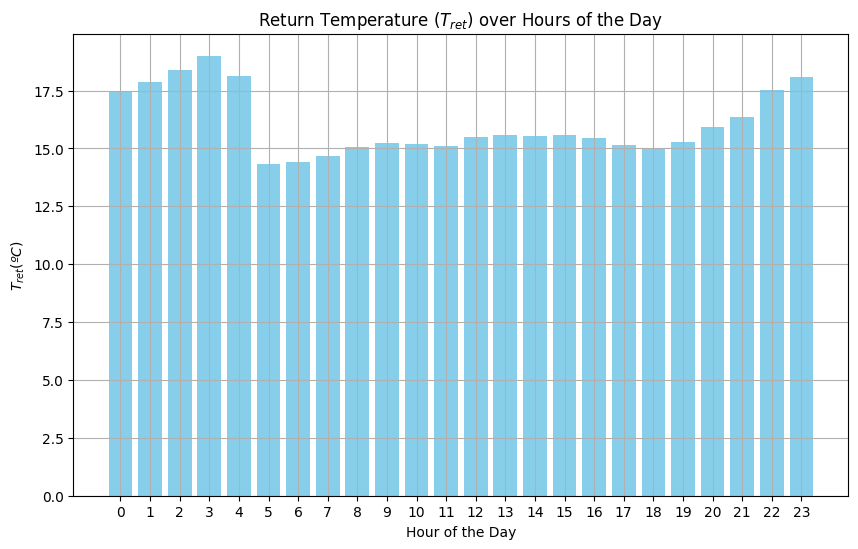

In [5]:
data_by_hour = df_date_sorted.groupby(df_date_sorted["hour"])["T_ret"].mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(data_by_hour.index, data_by_hour, color='skyblue') # data_by_hour is a pandas series, not a dataframe (it does not have column names)
plt.xlabel("Hour of the Day")  # Custom x label using Matplotlib
plt.ylabel("$T_{ret} (ºC)$")  # Custom y label
plt.title("Return Temperature ($T_{ret}$) over Hours of the Day")
plt.xticks(range(0, 24))  # Setting x-ticks for each hour
plt.grid(True)

And what is the average value for each day of the week?

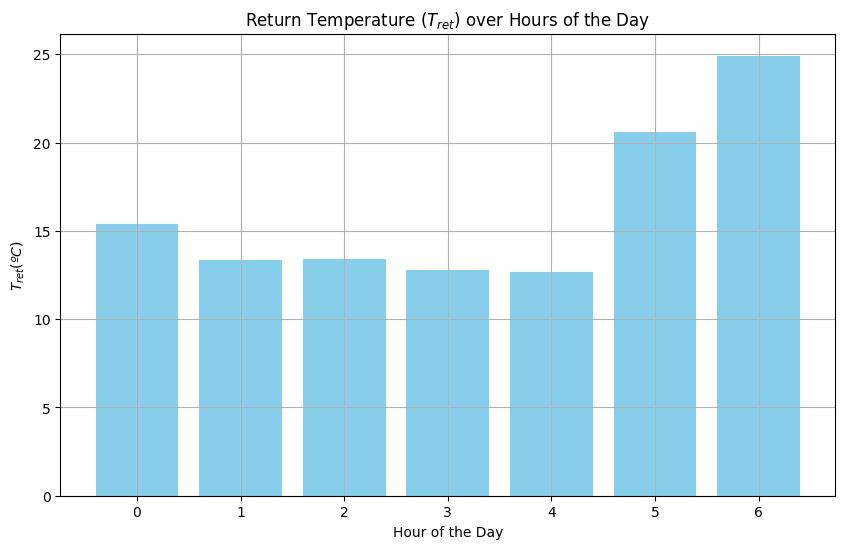

In [6]:
data_by_hour = df_date_sorted.groupby(df_date_sorted["dayofweek"])["T_ret"].mean()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(data_by_hour.index, data_by_hour, color='skyblue') # data_by_hour is a pandas series, not a dataframe (it does not have column names)
plt.xlabel("Hour of the Day")  # Custom x label using Matplotlib
plt.ylabel("$T_{ret} (ºC)$")  # Custom y label
plt.title("Return Temperature ($T_{ret}$) over Hours of the Day")
plt.xticks(range(0, 7))  # Setting x-ticks for each hour
plt.grid(True)

What is the average T_ret value for each day of the week for each month?

In [7]:
series_by_month_and_day = df_date_sorted.groupby([df_date_sorted["month"], df_date_sorted["dayofweek"]])["T_ret"].mean()
df_by_month_and_day = series_by_month_and_day.reset_index(name='T_ret')

Plot using pandas

Text(0.5, 1.0, 'Average T_ret by Day of Week for Each Month')

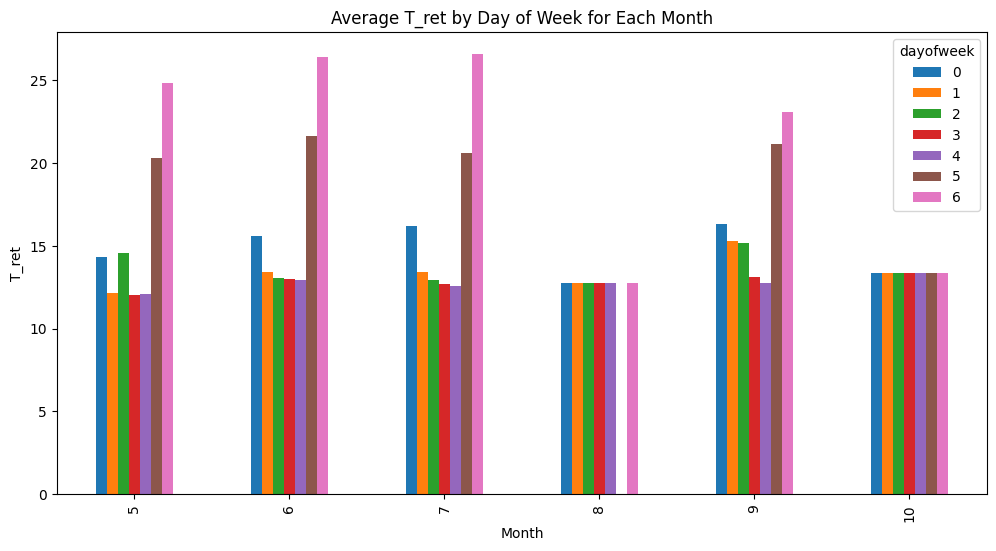

In [8]:
# Plotting the series data in a bar diagram
# First, unstack the series to create a DataFrame suitable for a bar plot
pivot = series_by_month_and_day.unstack(level=-1)

# Plotting using pandas built-in plot function
ax = pivot.plot(kind='bar', figsize=(12, 6), legend=True)

# Setting labels and title
ax.set_xlabel('Month')
ax.set_ylabel('T_ret')
ax.set_title('Average T_ret by Day of Week for Each Month')

Plot using matplotlib

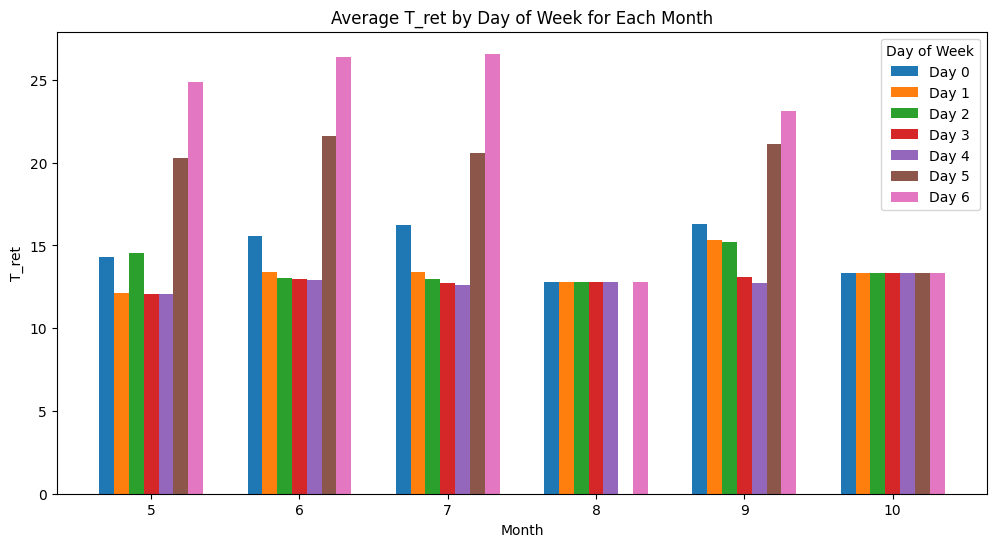

In [9]:
# Now we will plot directly with matplotlib
fig, ax = plt.subplots(figsize=(12, 6))

# We need to calculate the bar positions and width
bar_width = 0.1  # width of bars
num_bars = len(pivot.columns)  # number of bars per group
total_width = num_bars * bar_width  # total width of a group of bars
positions = range(len(pivot))  # positions for the first set of bars

# Plotting each set of bars
for i in range(num_bars):
    ax.bar([p + bar_width * i for p in positions], pivot.iloc[:, i], width=bar_width, label='Day {}'.format(pivot.columns[i]))

# Setting the position and labels for the x-axis
ax.set_xticks([p + total_width/2 - bar_width/2 for p in positions])
ax.set_xticklabels(pivot.index)

# Adding labels and title
ax.set_xlabel('Month')
ax.set_ylabel('T_ret')
ax.set_title('Average T_ret by Day of Week for Each Month')
ax.legend(title='Day of Week')

## Datetime as index

In [10]:
# Converting the 'datetime' column to the index of the DataFrame
df_date_index = df_date_sorted.set_index('datetime')
df_date_index.head() 

,dayofweek,day,month,hour,minute,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
datetime,,,,,,,,,,,,,,,,,
2022-05-13 12:00:00+00:00,4,13,5,12,0,24.40,874.0,9.880005,3.05,16.5,15.70,0.25,2923.0,2476.0,0.0,3153.0,10.869995
2022-05-13 12:01:00+00:00,4,13,5,12,1,NaN,NaN,NaN,3.05,16.3,15.70,0.25,2923.0,2476.0,0.0,3153.0,NaN
2022-05-13 12:02:00+00:00,4,13,5,12,2,24.35,875.0,9.940002,3.10,16.4,15.75,0.30,2793.0,2476.0,0.0,3211.0,10.750000
2022-05-13 12:03:00+00:00,4,13,5,12,3,NaN,NaN,NaN,3.10,16.5,15.65,0.25,2793.0,2606.0,0.0,3196.0,NaN
2022-05-13 12:04:00+00:00,4,13,5,12,4,24.51,875.0,9.940002,3.05,16.4,15.55,0.25,2779.0,2505.0,0.0,3196.0,10.899994


Slice T_ret data by date: from 2022-05-13 at 12:00 to 2022-05-14 at 12:00

Text(0.5, 1.0, 'T_ret from 2022-05-13 to 2022-05-14')

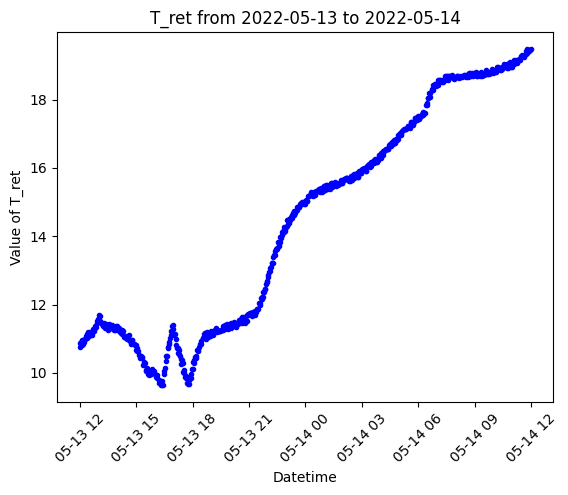

In [11]:
sliced_df = df_date_index["2022-05-13 12:00":"2022-05-14 12:00"]
plt.plot(sliced_df.index, sliced_df['T_ret'], marker='.', color='blue')
plt.xticks(rotation=45)
plt.xlabel("Datetime")
plt.ylabel("Value of T_ret")
plt.title("T_ret from 2022-05-13 to 2022-05-14")

If we plot it with pandas, x axis ticks have more clear names

<Axes: xlabel='datetime'>

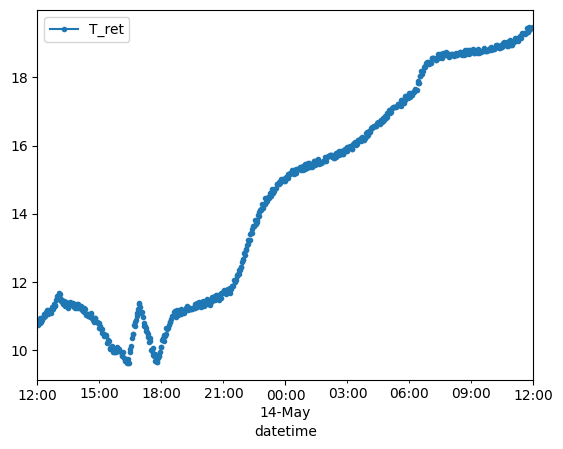

In [12]:
sliced_df[['T_ret']].plot(marker='.')

## Resample a time series to another frequency

The resample function is very flexible and allows you to specify many different parameters to control the frequency conversion and resampling operation.
- Aggregation functions: sum, mean, std, sem, max, min, median, first, last, ohlc
- A number of string aliases are given to useful common time series frequencies: 
  - B business day frequency
  - D calendar day frequency
  - W weekly frequency
  - M month end frequency
  - H hourly frequency
  - T minutely frequency
  - S secondly  frequency

For example, the following dataframes has 6 rows. Every row represents a month and the values of the columns are the average for that month

In [13]:
df_date_index.resample("M").mean()

,dayofweek,day,month,hour,minute,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
datetime,,,,,,,,,,,,,,,,,
2022-05-31 00:00:00+00:00,3.027027,22.243243,5.0,11.662162,29.500000,22.168988,273.568940,15.886844,3.932076,7.981988,5.857248,0.265298,1012.004992,914.213176,0.007920,1191.106794,16.348130
2022-06-30 00:00:00+00:00,2.966684,15.500093,6.0,11.501320,29.498217,24.709979,285.183527,15.030250,7.339296,12.617007,7.455367,0.464245,1188.151338,1072.627512,162.012272,1145.768431,15.815488
2022-07-31 00:00:00+00:00,3.170122,15.667789,7.0,11.504028,29.461567,26.595429,276.003361,15.903495,8.189658,13.083735,9.531757,1.426271,1141.545704,1028.773936,1153.586710,1196.765793,16.685987
2022-08-31 00:00:00+00:00,2.783147,19.606801,8.0,11.577454,29.500337,25.772014,228.226228,11.070007,5.393412,21.132283,0.269966,1.397382,1213.276557,1097.079693,1124.255788,0.133292,12.770020
2022-09-30 00:00:00+00:00,3.033337,15.500058,9.0,11.501215,29.498669,21.948185,175.105200,15.928481,5.914700,13.892371,6.868601,0.406932,2420.580723,2173.797296,136.822625,2692.200111,17.222119
2022-10-31 00:00:00+00:00,3.555281,5.000386,10.0,11.499113,29.497724,19.344489,153.768981,10.869995,3.177390,9.679917,4.958456,0.273899,2784.781035,2505.988195,0.019443,3299.993365,13.339996


The same can be done for day intervals and only for one column.

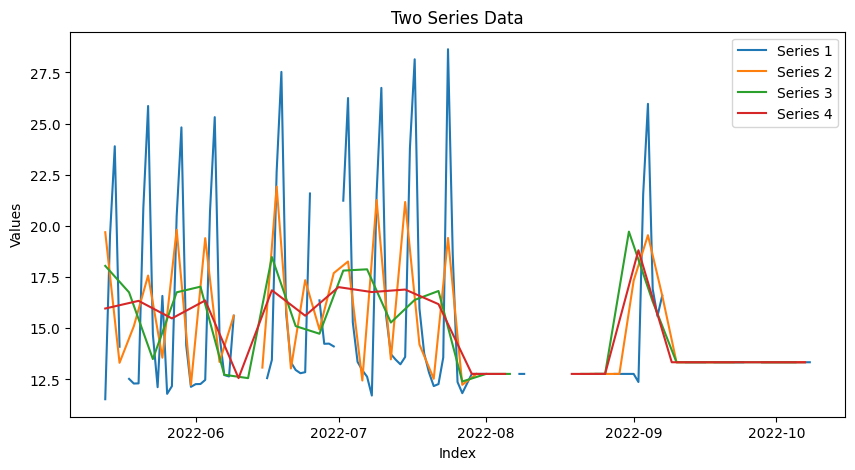

In [14]:
series1 = df_date_index['T_ret'].resample("1d").mean()
series2 = df_date_index['T_ret'].resample("3d").mean()
series3 = df_date_index['T_ret'].resample("5d").mean()
series4 = df_date_index['T_ret'].resample("7d").mean()

# Plotting the series
plt.figure(figsize=(10, 5))
plt.plot(series1, label='Series 1')
plt.plot(series2, label='Series 2')
plt.plot(series3, label='Series 3')
plt.plot(series4, label='Series 4')

plt.title('Two Series Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# NaN data exploration

At a glance, BC2, and Refr appear to be completely populated, while Temp information seems to be spottier.

The sparkline at right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

<Axes: >

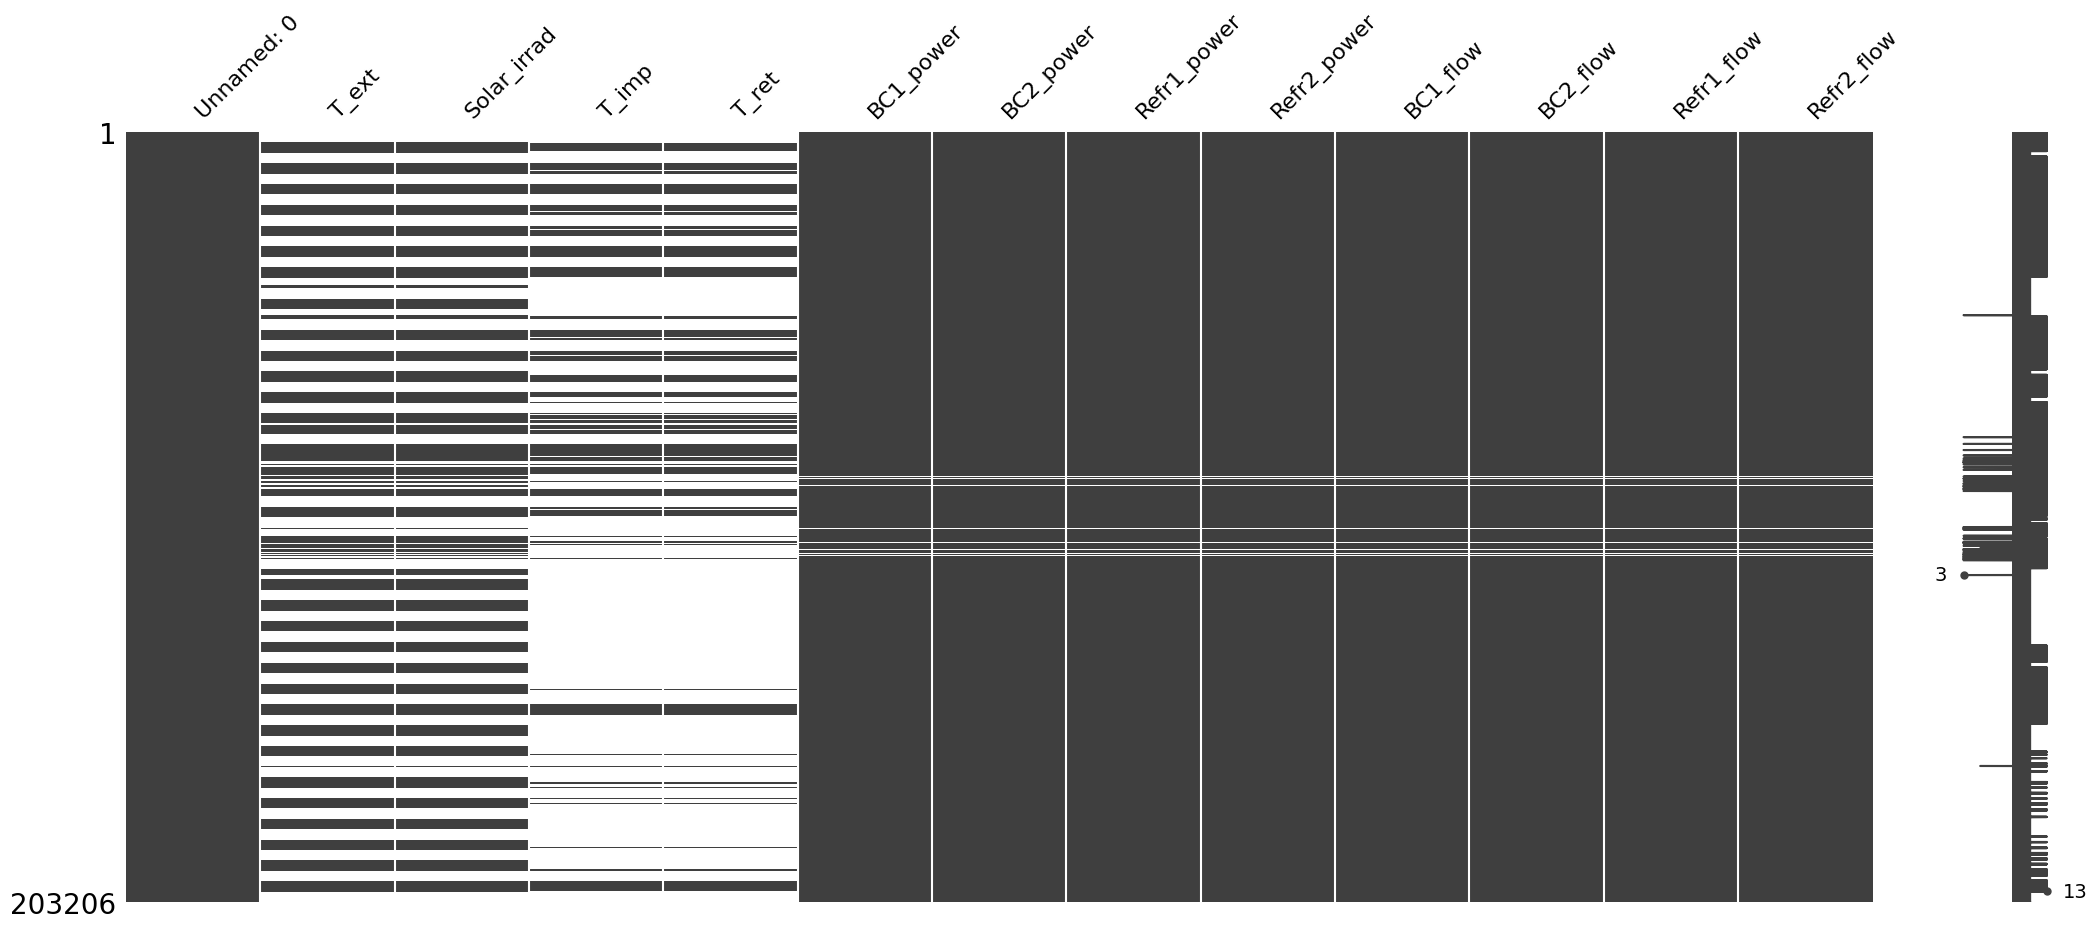

In [15]:
import missingno as msno
msno.matrix(df)

Bar chart provides a simple visualization of nullity by column:

<Axes: >

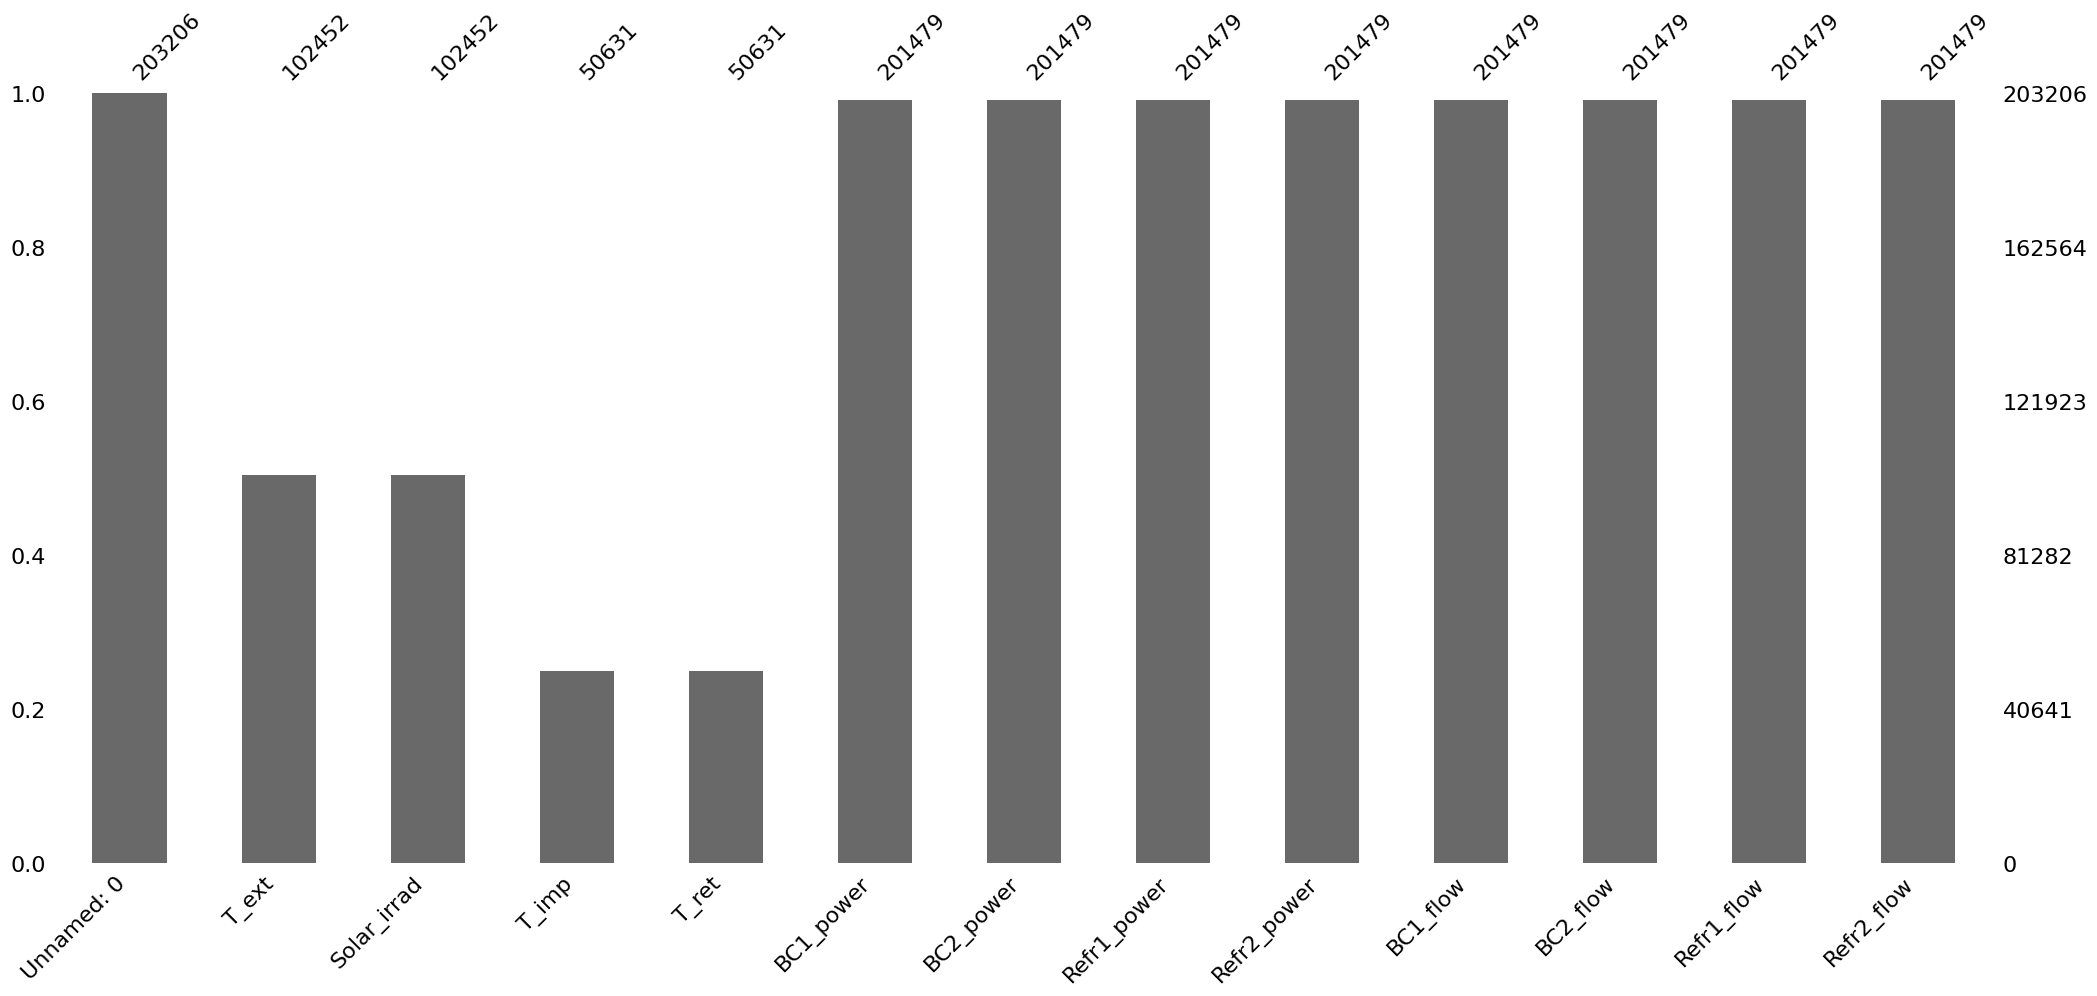

In [16]:
msno.bar(df)

Finally, the correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another.

Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

<Axes: >

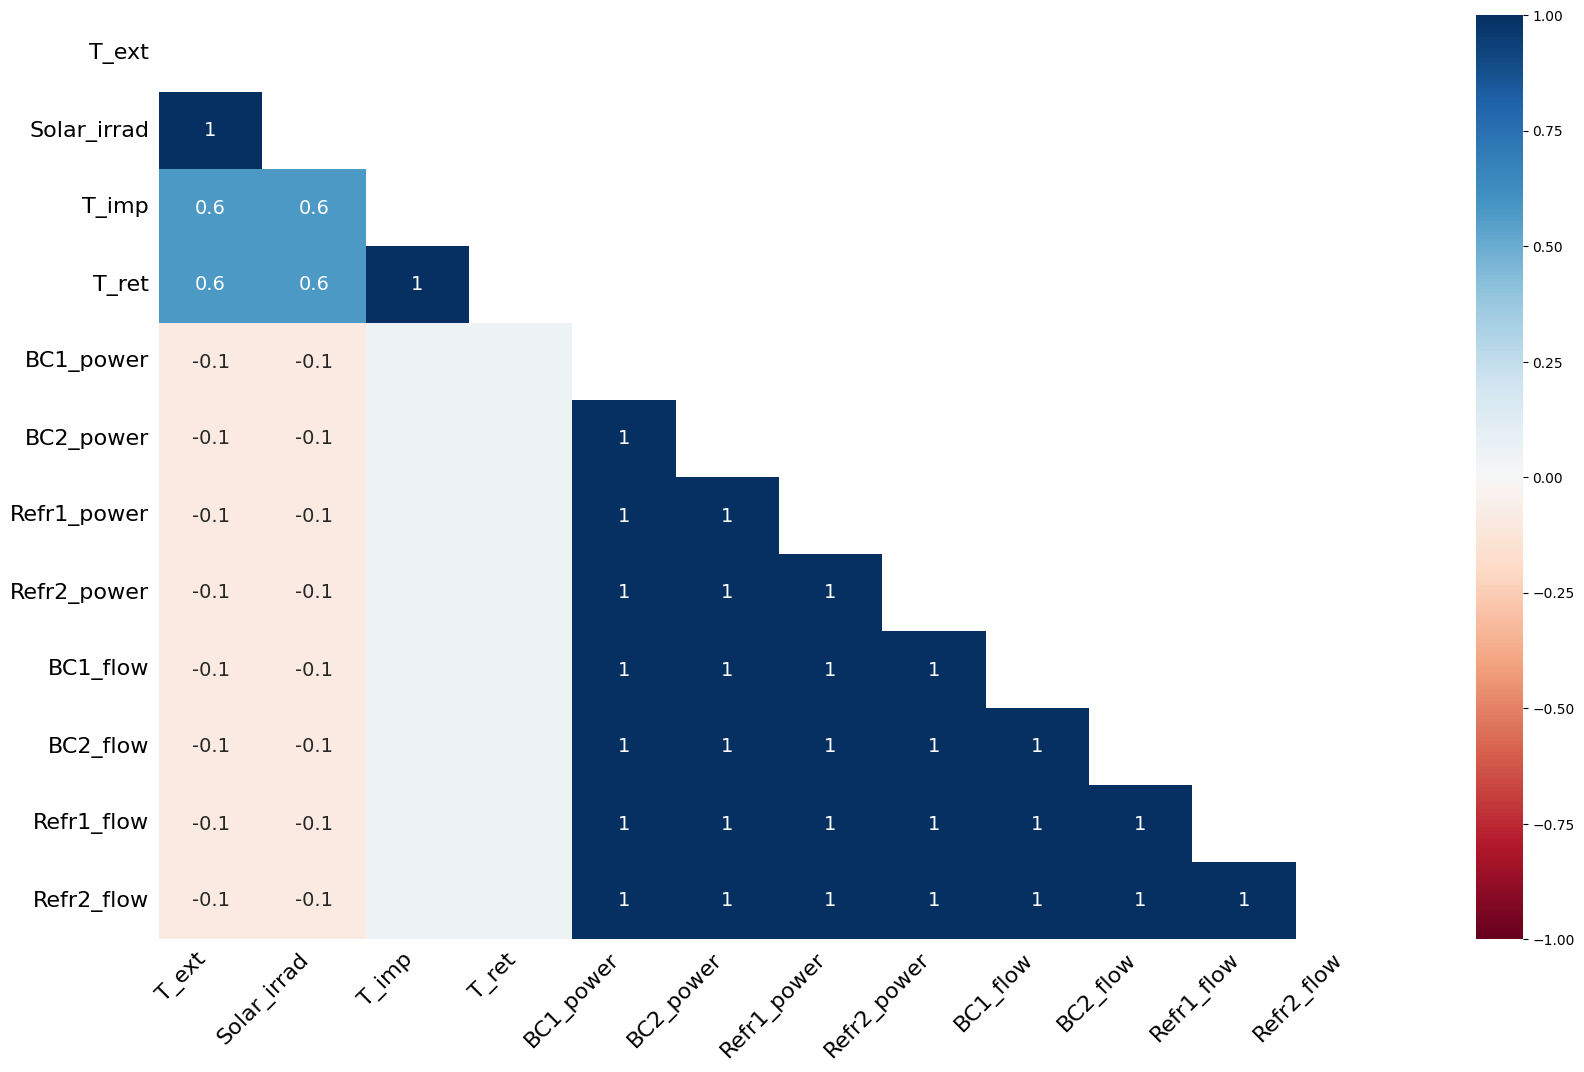

In [17]:
msno.heatmap(df)

# Data processing

In [18]:
# Handle missing data by interpolation
a = df_date_index.interpolate(method='linear')

# Filter out rows where any data is missing
b = df_date_index.dropna()

# Further filter the data to keep records with a 2-minute interval
c = df_date_index.resample('2T').mean()